# Ivancich Stefano 1227846
# HOMEWORK 3 - Deep Reinforcement Learning

 

In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# 1) CartPole gym environment

## 1.1) Experience replay (Replay Memory)

In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [3]:
######## TEST IF THE MEMORY WORKS ###########à
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
    print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(5, 5, 5, 5), (3, 3, 3, 3)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (5, 5, 5, 5)]


## 1.2) Policy network
The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 64 neurons each). 

Be sure to keep a linear output activation.

In [4]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [5]:
# Define an example network
state_space_dim=4
net = DQN(state_space_dim=state_space_dim, action_space_dim=2)

## 1.3) Exploration Policy
Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### 1.3.1) Epsilon-greedy policy
Choose a non optimal action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [6]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [7]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [0.106577   0.03485965]


### 1.3.2) Softmax policy
With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature  𝜏 ) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

In [8]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [9]:
# Test if it works as expected
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 0
Q-VALUES: [0.106577   0.03485965]


### 1.3.3) Exploration profile
Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

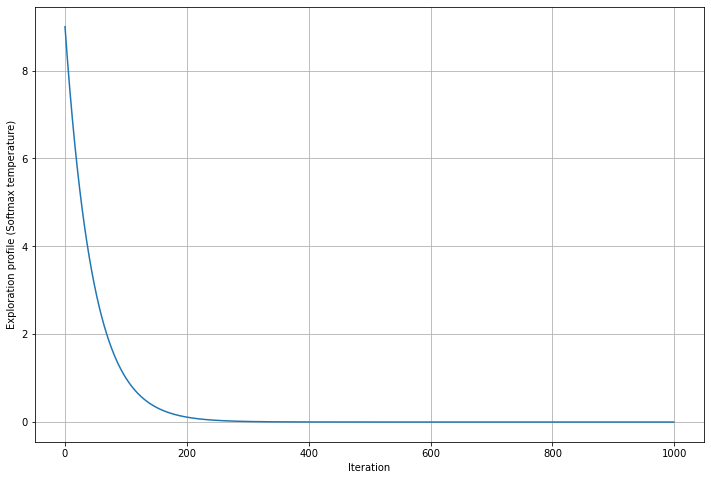

In [10]:
### Define exploration profile
initial_value = 9
#num_iterations = 1000
num_iterations = 1000

exp_decay = np.exp(-np.log(initial_value) / num_iterations * 10) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

## 1.4) Gym Environment (CartPole-v1)
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [11]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


### 1.4.1) Test Environment with a Random Agent

In [12]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 80.0
EPISODE 2 - FINAL SCORE: 24.0
EPISODE 3 - FINAL SCORE: 12.0
EPISODE 4 - FINAL SCORE: 22.0
EPISODE 5 - FINAL SCORE: 24.0
EPISODE 6 - FINAL SCORE: 15.0
EPISODE 7 - FINAL SCORE: 41.0
EPISODE 8 - FINAL SCORE: 12.0
EPISODE 9 - FINAL SCORE: 32.0
EPISODE 10 - FINAL SCORE: 30.0


## 1.5) Network update

### 1.5.1) Initialization

In [13]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
"""gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
"""

gamma = 0.98   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [14]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

### 1.5.2) Update function

In [15]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## 1.6) Training loop

In [16]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

scores=[]
last_scores=deque() #used for early stopping

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    
    scores.append(score)
    #Early stopping:after 12 perfect scores not need to learn more
    last_scores.append(score)
    if len(last_scores)>12:last_scores.popleft()
    if sum(last_scores)//12==500: break

env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 9.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 8.80440647156254
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 8.613063701832482
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 8.42587931071048
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 8.242762925758251
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 8.06362613856686
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 7.8883824620732135
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 7.716947288804205
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 7.549237850028304
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 7.385173175794898
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 7.224674055842075
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 7.067663001353995
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 6.91406420754936
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 6.7638035170829465
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 6.616808384242507
EPISODE: 16 - FINAL SCORE:

EPISODE: 125 - FINAL SCORE: 51 - Temperature: 0.5901763440261123
EPISODE: 126 - FINAL SCORE: 32 - Temperature: 0.5773502691896248
EPISODE: 127 - FINAL SCORE: 13 - Temperature: 0.5648029384901675
EPISODE: 128 - FINAL SCORE: 21 - Temperature: 0.5525282940889301
EPISODE: 129 - FINAL SCORE: 23 - Temperature: 0.5405204097997763
EPISODE: 130 - FINAL SCORE: 75 - Temperature: 0.5287734882280875
Updating target network...
EPISODE: 131 - FINAL SCORE: 20 - Temperature: 0.5172818579717857
EPISODE: 132 - FINAL SCORE: 59 - Temperature: 0.5060399708831872
EPISODE: 133 - FINAL SCORE: 22 - Temperature: 0.4950423993903615
EPISODE: 134 - FINAL SCORE: 52 - Temperature: 0.48428383387670515
EPISODE: 135 - FINAL SCORE: 16 - Temperature: 0.4737590801174646
EPISODE: 136 - FINAL SCORE: 20 - Temperature: 0.46346305677196903
EPISODE: 137 - FINAL SCORE: 28 - Temperature: 0.45339079293036455
EPISODE: 138 - FINAL SCORE: 24 - Temperature: 0.4435374257136637
EPISODE: 139 - FINAL SCORE: 30 - Temperature: 0.433898197925

EPISODE: 245 - FINAL SCORE: 148 - Temperature: 0.04225623376350925
EPISODE: 246 - FINAL SCORE: 142 - Temperature: 0.041337895334588926
EPISODE: 247 - FINAL SCORE: 131 - Temperature: 0.040439514800514414
EPISODE: 248 - FINAL SCORE: 110 - Temperature: 0.03956065842405536
EPISODE: 249 - FINAL SCORE: 172 - Temperature: 0.03870090189422535
EPISODE: 250 - FINAL SCORE: 138 - Temperature: 0.03785983012142496
Updating target network...
EPISODE: 251 - FINAL SCORE: 142 - Temperature: 0.037037037037036924
EPISODE: 252 - FINAL SCORE: 122 - Temperature: 0.036232125397376594
EPISODE: 253 - FINAL SCORE: 189 - Temperature: 0.035444706591903116
EPISODE: 254 - FINAL SCORE: 378 - Temperature: 0.03467440045559858
EPISODE: 255 - FINAL SCORE: 328 - Temperature: 0.0339208350854248
EPISODE: 256 - FINAL SCORE: 323 - Temperature: 0.03318364666076887
EPISODE: 257 - FINAL SCORE: 242 - Temperature: 0.0324624792677909
EPISODE: 258 - FINAL SCORE: 333 - Temperature: 0.03175698472758922
EPISODE: 259 - FINAL SCORE: 247 

EPISODE: 362 - FINAL SCORE: 105 - Temperature: 0.00323167032526473
EPISODE: 363 - FINAL SCORE: 64 - Temperature: 0.0031614376806352678
EPISODE: 364 - FINAL SCORE: 88 - Temperature: 0.003092731374980758
EPISODE: 365 - FINAL SCORE: 95 - Temperature: 0.0030255182369650106
EPISODE: 366 - FINAL SCORE: 108 - Temperature: 0.002959765816151692
EPISODE: 367 - FINAL SCORE: 95 - Temperature: 0.0028954423673372824
EPISODE: 368 - FINAL SCORE: 83 - Temperature: 0.002832516835224526
EPISODE: 369 - FINAL SCORE: 83 - Temperature: 0.002770958839428962
EPISODE: 370 - FINAL SCORE: 89 - Temperature: 0.0027107386598113088
Updating target network...
EPISODE: 371 - FINAL SCORE: 83 - Temperature: 0.002651827222128606
EPISODE: 372 - FINAL SCORE: 94 - Temperature: 0.0025941960839972016
EPISODE: 373 - FINAL SCORE: 82 - Temperature: 0.0025378174211607963
EPISODE: 374 - FINAL SCORE: 78 - Temperature: 0.0024826640140569187
EPISODE: 375 - FINAL SCORE: 85 - Temperature: 0.002428709234675352
EPISODE: 376 - FINAL SCORE:

EPISODE: 479 - FINAL SCORE: 83 - Temperature: 0.00024715153625961314
EPISODE: 480 - FINAL SCORE: 85 - Temperature: 0.0002417802872556402
Updating target network...
EPISODE: 481 - FINAL SCORE: 96 - Temperature: 0.0002365257695344232
EPISODE: 482 - FINAL SCORE: 83 - Temperature: 0.00023138544622002062
EPISODE: 483 - FINAL SCORE: 90 - Temperature: 0.0002263568355694373
EPISODE: 484 - FINAL SCORE: 94 - Temperature: 0.00022143750977444128
EPISODE: 485 - FINAL SCORE: 88 - Temperature: 0.00021662509378942045
EPISODE: 486 - FINAL SCORE: 90 - Temperature: 0.00021191726418471284
EPISODE: 487 - FINAL SCORE: 101 - Temperature: 0.00020731174802485718
EPISODE: 488 - FINAL SCORE: 94 - Temperature: 0.00020280632177122168
EPISODE: 489 - FINAL SCORE: 90 - Temperature: 0.00019839881020848214
EPISODE: 490 - FINAL SCORE: 83 - Temperature: 0.00019408708539442982
Updating target network...
EPISODE: 491 - FINAL SCORE: 101 - Temperature: 0.00018986906563260323
EPISODE: 492 - FINAL SCORE: 89 - Temperature: 0.00

EPISODE: 594 - FINAL SCORE: 500 - Temperature: 1.975078804762568e-05
EPISODE: 595 - FINAL SCORE: 500 - Temperature: 1.932155178944173e-05
EPISODE: 596 - FINAL SCORE: 500 - Temperature: 1.8901643957287953e-05
EPISODE: 597 - FINAL SCORE: 500 - Temperature: 1.8490861820079674e-05
EPISODE: 598 - FINAL SCORE: 500 - Temperature: 1.8089007052608683e-05
EPISODE: 599 - FINAL SCORE: 500 - Temperature: 1.7695885639792035e-05
EPISODE: 600 - FINAL SCORE: 500 - Temperature: 1.7311307783001736e-05
Updating target network...
EPISODE: 601 - FINAL SCORE: 500 - Temperature: 1.6935087808430164e-05
EPISODE: 602 - FINAL SCORE: 500 - Temperature: 1.6567044077446932e-05



Text(0, 0.5, 'Scores')

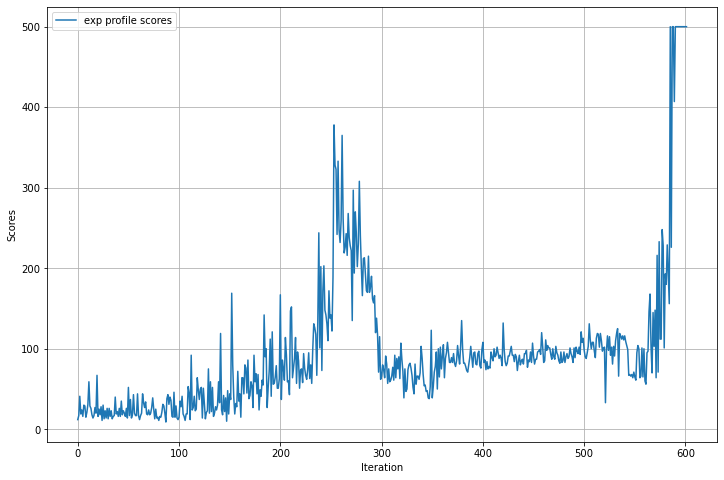

In [17]:
### Plot exp exploration profile
plt.figure(figsize=(12,8))
plt.plot(scores, label='exp profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

## 1.7) Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        #env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

---
---
---
# 2) Control CartPole using screen pixels

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

## 2.1) Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## 2.2) Policy network

### 2.2.1) Fully connected

In [ ]:
#Simple FC
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

### 2.2.2) Convolutional

In [ ]:
#CNN
class DQN(nn.Module):

    def __init__(self, channels, action_space_dim):
        super().__init__()
        
        self.conv = nn.Sequential(
            # Size = 1x128x192
            nn.Conv2d(in_channels = channels, out_channels = 64, kernel_size = 4, stride = 2, padding=0),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),

            #Size 64x64x96
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=0),
            #nn.BatchNorm2d(128),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),

            #Size 128x32x48
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            #nn.BatchNorm2d(256),
            #nn.LeakyReLU(0.2, inplace=True),
            nn.ReLU(),

            #Size 128x16x24
            #nn.Conv2d(in_channels=64, out_channels=16, kernel_size=4, stride=4, padding=1),
            #nn.BatchNorm2d(16),
            #nn.LeakyReLU(0.2, inplace=True),

            #Size 16x4x6
            )
        
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25024, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
            )
        

    def forward(self, x):
        x=self.conv(x)
        #print(x.shape)
        return self.linear(x)
    
    
"""
input: 1x85x200
Conv1: 64x41x99
Conv2: 64x19x48
Conv3: 32x17x46
Flatten: 25024
FC1: 128
FC2: 128
Out: 2



After Conv: (input_size - kernel_size + 2*padding)/stride +1
After Maxpool:(input_size - kernel_size + 2*padding)/stride +1
"""

## 2.3) Exploration Policy
### 2.3.1) Epsilon-greedy policy

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### 2.3.2) Softmax policy

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out[0] / temperature, dim=0).numpy()
    #print(softmax_out.shape)
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### 2.3.3) Exploration profile

In [ ]:
### Define exploration profile
initial_value = 5
#num_iterations = 1000
num_iterations = 1000

exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

## 2.4) Network update
### 2.4.1) Initialization

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
"""gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
"""

gamma = 0.98   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

#state_space_dim=43*100
state_space_dim=172*400

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
#policy_net = DQN(state_space_dim, action_space_dim) #FC
policy_net = DQN(1, action_space_dim) #CNN

### Initialize the target network with the same weights of the policy network
#target_net = DQN(state_space_dim, action_space_dim)#FC
target_net = DQN(1, action_space_dim)#CNN
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()


"""from torchsummary import summary
dqn.to(device)
summary(dqn, input_size=(3,80,80))"""

### 2.5.2) Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    #states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    #states      = torch.stack([s[0] for s in batch]) #FC
    states      = torch.stack([s[0][0] for s in batch]) #CNN
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    #non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    #non_final_next_states = torch.stack([s[2] for s in batch if s[2] is not None]) #FC
    non_final_next_states = torch.stack([s[2][0] for s in batch if s[2] is not None]) #CNN
    
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    #print(states[0].shape)
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## 2.6) Image Cutting and rescaling the Image

In [ ]:
def preproces(statePixel):
    statePixel=statePixel[150:320,100:500,2]
    #statePixel = statePixel.reshape((1,43, 4, 100, 4)).max(4).max(2)  #Reshape 4 time smaller
    statePixel = statePixel.reshape((1,85, 2, 200, 2)).max(4).max(2)  #Reshape 2 times smaller
    statePixel = torch.tensor(statePixel.copy(), dtype=torch.float32)
    #statePixel=torch.flatten(statePixel)
    return statePixel

In [ ]:
#Test image rescaling

env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

state = env.reset()
statePixel= env.render(mode='rgb_array')

statePixel=preproces(statePixel)

env.close()



img=statePixel
img=img.unsqueeze(0)
print(img.shape)
plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
plt.show()



## 2.7) Training

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

scores=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    statePixel= env.render(mode='rgb_array')
    statePixel=preproces(statePixel)
    statePixel=statePixel.unsqueeze(0) #cnn
    #statePixel=torch.flatten(statePixel)
    
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, statePixel, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty when the cart is far from center
        pos_weight = 1
        reward = reward - pos_weight * np.abs(state[0]) 
        

        # Update the final score (+1 for each step)
        score += 1

        # Apply penalty for bad state
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
            next_state_Pixel=None
            
        if type(next_state)!="NoneType":
            next_state_Pixel= env.render(mode='rgb_array')
            next_state_Pixel = preproces(next_state_Pixel)
            next_state_Pixel=next_state_Pixel.unsqueeze(0) #cnn
            #img=next_state_Pixel
            #plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
            #plt.show()
            
            #next_state_Pixel=torch.flatten(next_state_Pixel)
            

        # Update the replay memory
        replay_mem.push(statePixel, action, next_state_Pixel, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state
        statePixel=next_state_Pixel

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
        
        """aaa= env.render(mode='rgb_array')
        aaa = preproces(aaa)
        img=aaa
        plt.imshow(img.cpu().squeeze().numpy(),cmap='gray')
        plt.show()"""
    if episode_num==15:break

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    
    scores.append(score)

env.close()

In [ ]:
### Plot exp exploration profile
plt.figure(figsize=(12,8))
plt.plot(scores, label='exp profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

## 2.8) Final Test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    statePixel= env.render(mode='rgb_array')
    statePixel=preproces(statePixel)
    statePixel=statePixel.unsqueeze(0) #cnn
    #statePixel=torch.flatten(statePixel)#fc
    
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        #print(statePixel.shape)
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, statePixel, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        #env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        
        if done: # if the pole has fallen down
            next_state = None
            next_state_Pixel=None
        if type(next_state)!="NoneType":
            next_state_Pixel= env.render(mode='rgb_array')
            next_state_Pixel = preproces(next_state_Pixel)
            next_state_Pixel=next_state_Pixel.unsqueeze(0) #cnn
            #next_state_Pixel=torch.flatten(next_state_Pixel)
        state = next_state
        statePixel=next_state_Pixel
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

---
---
---
---
---

# 3) MountainCar-v0 gym environment


## 3.1) Initialize

In [16]:
### Create environment
env = gym.make('MountainCar-v0') # Initialize the Gym environment

env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 2
ACTION SPACE SIZE: 3


In [17]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [18]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

## 3.2) Train

In [19]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(0) # Set a random seed for the environment (reproducible results)

scores=[]
last_scores=deque() #used for early stopping

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

        # Choose the action following the policy
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)

        # We apply a (linear) penalty 
        pos_weight = 6
        
        if (action ==0 and state[1]<0) or (action==2 and state[1]>0):
            reward= reward + pos_weight * np.abs(state[0]+0.5)
        else:reward= reward-2

        # Score= position
        score=state[0]

        # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

        # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

        # Visually render the environment (disable to speed up the training)
        #env.render()

        # Set the current state for the next iteration
        state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau} - REW: {reward}") # Print the final score

    scores.append(score)
    #Early stopping:after 12 perfect scores not need to learn more
    last_scores.append(score)
    if len(last_scores)>10:last_scores.popleft()
    if sum(last_scores)/10>=0.48: break
    
env.close()

Updating target network...
EPISODE: 1 - FINAL SCORE: -0.46158377387638805 - Temperature: 9.0 - REW: -3.0
EPISODE: 2 - FINAL SCORE: -0.5427428986061522 - Temperature: 8.80440647156254 - REW: -0.7435426083630867
EPISODE: 3 - FINAL SCORE: -0.5302125688191489 - Temperature: 8.613063701832482 - REW: -0.8187245870851065
EPISODE: 4 - FINAL SCORE: -0.5015577286964845 - Temperature: 8.42587931071048 - REW: -3.0
EPISODE: 5 - FINAL SCORE: -0.48137046894444135 - Temperature: 8.242762925758251 - REW: -3.0
EPISODE: 6 - FINAL SCORE: -0.3766767053669488 - Temperature: 8.06362613856686 - REW: -3.0
EPISODE: 7 - FINAL SCORE: -0.6404050140048644 - Temperature: 7.8883824620732135 - REW: -0.1575699159708137
EPISODE: 8 - FINAL SCORE: -0.6614901704931742 - Temperature: 7.716947288804205 - REW: -3.0
EPISODE: 9 - FINAL SCORE: -0.5370620247207326 - Temperature: 7.549237850028304 - REW: -0.7776278516756043
EPISODE: 10 - FINAL SCORE: -0.41187097482369867 - Temperature: 7.385173175794898 - REW: -3.0
Updating target

EPISODE: 83 - FINAL SCORE: -0.2591077761826785 - Temperature: 1.4851271981710852 - REW: -3.0
EPISODE: 84 - FINAL SCORE: -0.6055980916069474 - Temperature: 1.4528515016301162 - REW: -0.36641145035831535
EPISODE: 85 - FINAL SCORE: -0.6466842711576525 - Temperature: 1.4212772403523946 - REW: -3.0
EPISODE: 86 - FINAL SCORE: -0.40010205941486304 - Temperature: 1.390389170315908 - REW: -3.0
EPISODE: 87 - FINAL SCORE: -0.6614729536869943 - Temperature: 1.3601723787910944 - REW: -3.0
EPISODE: 88 - FINAL SCORE: -0.5495509203972859 - Temperature: 1.330612277140992 - REW: -3.0
EPISODE: 89 - FINAL SCORE: -0.6106752187472011 - Temperature: 1.3016945937778575 - REW: -3.0
EPISODE: 90 - FINAL SCORE: -0.7812485481247572 - Temperature: 1.27340536727286 - REW: -3.0
Updating target network...
EPISODE: 91 - FINAL SCORE: -0.5370601744166136 - Temperature: 1.245730939615516 - REW: -3.0
EPISODE: 92 - FINAL SCORE: -0.4749255472833831 - Temperature: 1.2186579496196148 - REW: -3.0
EPISODE: 93 - FINAL SCORE: -0.4

Text(0, 0.5, 'Scores')

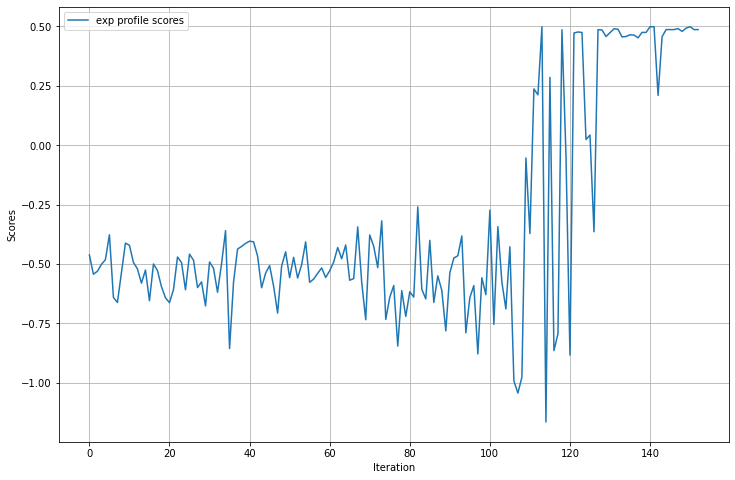

In [20]:
### Plot exp exploration profile
plt.figure(figsize=(12,8))
plt.plot(scores, label='exp profile scores')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Scores')

## 3.3) Test

In [21]:
# Initialize the Gym environment
env = gym.make('MountainCar-v0') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score = next_state[0]
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 0.5014211263106032
EPISODE 2 - FINAL SCORE: 0.5368577983788596
EPISODE 3 - FINAL SCORE: 0.5368577983788596
EPISODE 4 - FINAL SCORE: 0.5368577983788596
EPISODE 5 - FINAL SCORE: 0.5102396132823923
EPISODE 6 - FINAL SCORE: 0.5368577983788596
EPISODE 7 - FINAL SCORE: 0.5368577983788596
EPISODE 8 - FINAL SCORE: 0.5368577983788596
EPISODE 9 - FINAL SCORE: 0.5131787950789455
EPISODE 10 - FINAL SCORE: 0.5368577983788596
